In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2024-06-17 02:00:34.051663: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 各パス指定

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [3]:
NUM_CLASSES = 6

# 学習データ読み込み

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 6)                 66        
                                                                 
Total params: 1136 (4.44 KB)
Trainable params: 1136 (4.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
25/25 [==============================] - ETA: 0s - loss: 1.7156 - accuracy: 0.2409 
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
25/25 [==============================] - 1s 15ms/step - loss: 1.7156 - accuracy: 0.2409 - val_loss: 1.5410 - val_accuracy: 0.3311
Epoch 2/1000
25/25 [==============================] - ETA: 0s - loss: 1.5690 - accuracy: 0.3276
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
25/25 [==============================] - 0s 5ms/step - loss: 1.5690 - accuracy: 0.3276 - val_loss: 1.4165 - val_accuracy: 0.4107
Epoch 3/1000
 1/25 [>.............................] - ETA: 0s - loss: 1.4462 - accuracy: 0.3672

/opt/miniconda3/envs/ObjDetection/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/25 [==========================>...] - ETA: 0s - loss: 1.4702 - accuracy: 0.3781
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
25/25 [==============================] - 0s 6ms/step - loss: 1.4643 - accuracy: 0.3823 - val_loss: 1.2986 - val_accuracy: 0.5729
Epoch 4/1000
22/25 [=========================>....] - ETA: 0s - loss: 1.3827 - accuracy: 0.4169
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
25/25 [==============================] - 0s 5ms/step - loss: 1.3742 - accuracy: 0.4232 - val_loss: 1.1901 - val_accuracy: 0.6401
Epoch 5/1000
 1/25 [>.............................] - ETA: 0s - loss: 1.3763 - accuracy: 0.4453
Epoch 5: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
25/25 [==============================] - 0s 5ms/step - loss: 1.2832 - accuracy: 0.4866 - val_loss: 1.0839 - val_accuracy: 0.6699
Epoch 6/1000
 1/25 [>.............................] - ETA: 0s - loss: 1.2725 - accuracy: 0.5000
Epoch 6: savin

In [12]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

9/9 [==============================] - 0s 2ms/step - loss: 0.0850 - accuracy: 0.9971


In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 104ms/step
[3.3671437e-05 3.6896681e-03 8.5742044e-01 1.0757583e-01 3.1134605e-02
 1.4580497e-04]
2


# 混同行列

33/33 [==============================] - 0s 1ms/step


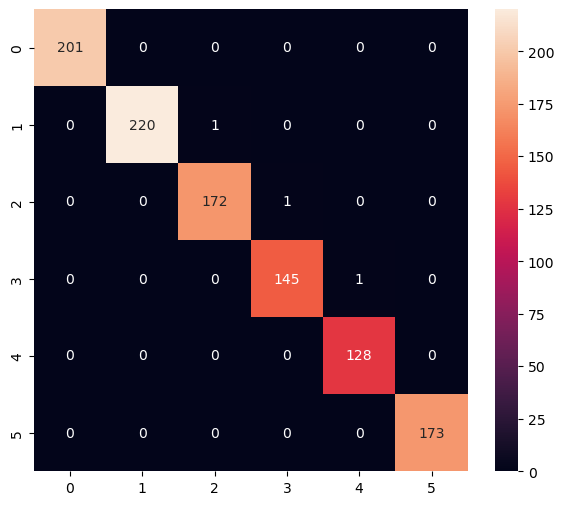

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       201
           1       1.00      1.00      1.00       221
           2       0.99      0.99      0.99       173
           3       0.99      0.99      0.99       146
           4       0.99      1.00      1.00       128
           5       1.00      1.00      1.00       173

    accuracy                           1.00      1042
   macro avg       1.00      1.00      1.00      1042
weighted avg       1.00      1.00      1.00      1042



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [16]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

/opt/miniconda3/envs/ObjDetection/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/8n/cssdjz7d5kx9htc_lkb6hf980000gn/T/tmpv57pwwyl/assets


INFO:tensorflow:Assets written to: /var/folders/8n/cssdjz7d5kx9htc_lkb6hf980000gn/T/tmpv57pwwyl/assets
2024-06-17 02:01:23.405485: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-06-17 02:01:23.406018: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-06-17 02:01:23.410170: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/8n/cssdjz7d5kx9htc_lkb6hf980000gn/T/tmpv57pwwyl
2024-06-17 02:01:23.411960: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-06-17 02:01:23.411978: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/8n/cssdjz7d5kx9htc_lkb6hf980000gn/T/tmpv57pwwyl
2024-06-17 02:01:23.419118: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-06-17 02:01:23.502438: I tensorflow/cc/saved_model/loader.cc:217] Running initialization

6632

# 推論テスト

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Initialized TensorFlow Lite runtime.
INFO: Applying 1 TensorFlow Lite delegate(s) lazily.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
VERBOSE: Replacing 4 out of 4 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions for the whole graph.
INFO: Successfully applied the default TensorFlow Lite delegate indexed at 0.
 *NOTE*: because a delegate has been applied, the precision of computations should be unchanged, but the exact output tensor values may have changed. If such output values are checked in your code, like in your tests etc., please consider increasing error tolerance for the check.


In [19]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 1.73 ms, sys: 2.58 ms, total: 4.31 ms
Wall time: 2.1 ms


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[3.3671400e-05 3.6896637e-03 8.5742033e-01 1.0757586e-01 3.1134598e-02
 1.4580481e-04]
2
